<a href="https://colab.research.google.com/github/Cebelle1/TinyML/blob/main/TinyML_%22Hello_World%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 'Hello world' of ML - Sine function model
### Train a model to predict its sine value y with input x without knowing the sin() function then deployed on Arduino Nano 33 BLE

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
#Generate data points
SAMPLES = 1000

#Set seed to get same balue each time we run notebook (can use any number)
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)  #set the global generate seed

In [3]:
x_values = np.random.uniform(low=0, high =2*math.pi, size = SAMPLES) #generate 0 to 2pi uniformly

#x_values
np.random.shuffle(x_values)


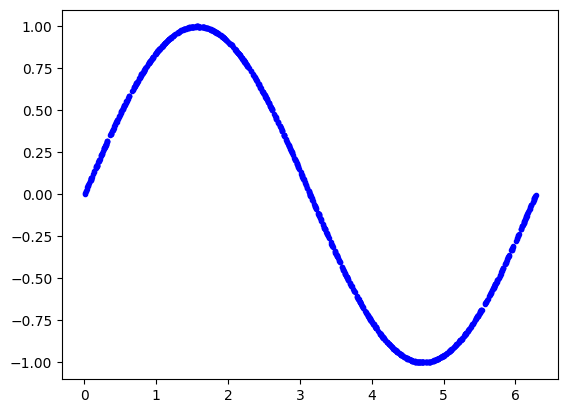

In [4]:
#y_values will be the expected output (correct output)
y_values = np.sin(x_values)

plt.plot(x_values,y_values,'b.')
plt.show()

Generating noisy data set

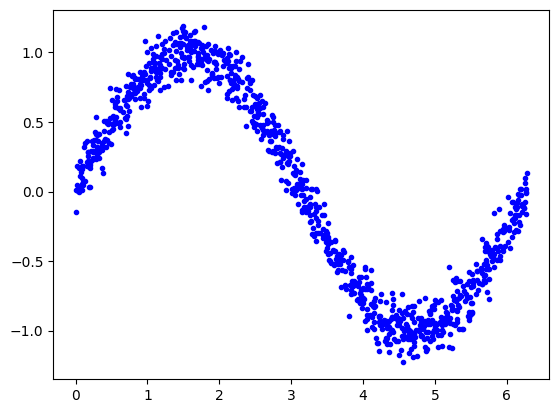

In [5]:
y_values += 0.1 * np.random.randn(*y_values.shape)
plt.plot(x_values, y_values, "b.")
plt.show()

Split Data set into Train (60%) | Test (20%) | Validate (20%)

In [6]:
TRAIN_SPLIT = int(0.6 * SAMPLES)
#For indexing, so TEST_SPLIT will end at 800, starting at 600
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)


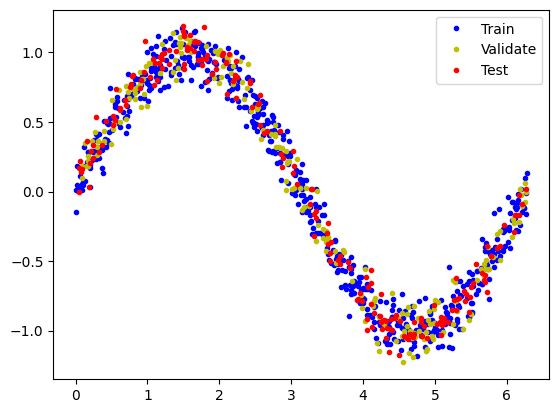

In [7]:
#np.split works by [split to, starting from previous to, remaining]
x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

#double check the size tallies (python assert() will return a error if false)
assert(x_train.size + x_validate.size + x_test.size) == SAMPLES

plt.plot(x_train, y_train, "b.", label = "Train")
plt.plot(x_validate, y_validate, "y.", label = "Validate")
plt.plot(x_test, y_test, "r.", label = "Test")
plt.legend()
plt.show()

Building the model
Orignal Activation: Relu (Bad predictions)
I change the activation to Sigmoid and the prediction is okay.

(I felt that sigmoid is better since the nature of their output values are continuous between -1 and 1)

In [8]:
from tensorflow.keras import layers
model_1 = tf.keras.Sequential()

#Feeds input through 16 neurons
#Decides which to acitivate base on 'relu'
model_1.add(layers.Dense(16, activation = 'sigmoid', input_shape=(1,)))

#Output layer (final) is a single neuron since we want a single y_value
model_1.add(layers.Dense(1))

#Compilse using standard optimizer and loss function for regression
#RMSProp = Root mean square prop > Back propogation, Gradient Descent technique with RMS to dratically reduce computational effort
#MSE = mean square error, MAE = mean absolute error
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model_1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 49 (196.00 Byte)
Trainable params: 49 (196.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training the model

In [9]:
history_1 = model_1.fit(x_train,y_train, epochs = 1000, batch_size = 16, validation_data = (x_validate, y_validate))

Epoch 1/1000
38/38 [==============================] - 1s 17ms/step - loss: 0.8869 - mae: 0.8099 - val_loss: 0.8072 - val_mae: 0.8070
Epoch 2/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.7099 - mae: 0.7659 - val_loss: 0.7126 - val_mae: 0.7657
Epoch 3/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.6342 - mae: 0.7234 - val_loss: 0.6353 - val_mae: 0.7228
Epoch 4/1000
38/38 [==============================] - 0s 5ms/step - loss: 0.5702 - mae: 0.6838 - val_loss: 0.5732 - val_mae: 0.6816
Epoch 5/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.5131 - mae: 0.6430 - val_loss: 0.5120 - val_mae: 0.6389
Epoch 6/1000
38/38 [==============================] - 0s 7ms/step - loss: 0.4569 - mae: 0.6012 - val_loss: 0.4611 - val_mae: 0.6005
Epoch 7/1000
38/38 [==============================] - 0s 4ms/step - loss: 0.4116 - mae: 0.5653 - val_loss: 0.4143 - val_mae: 0.5620
Epoch 8/1000
38/38 [==============================] - 0s 4ms/step - loss: 0

Graph the history
(should look into how to use %tensorboard next time)

**My validation loss is lesser than training loss, hence not overfitted. But the loss grows stagnant over time, so theres no time having 1000 epoch, since more redundant training only uses up a lot of computational resources. Should find the optimal epoch.**

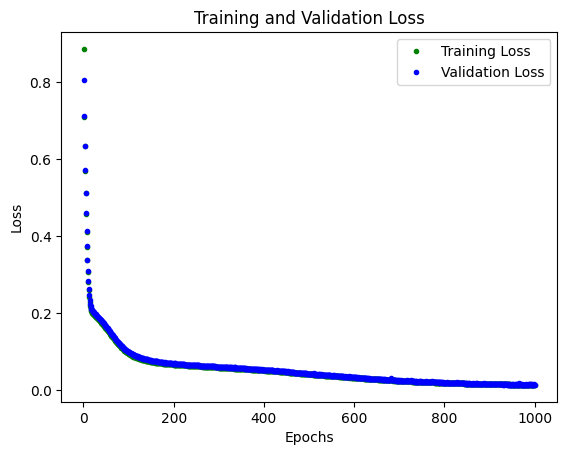

In [10]:
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epoch = range(1,len(loss)+1)

plt.plot(epoch, loss, 'g.', label = 'Training Loss')
plt.plot(epoch, val_loss, 'b.', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Zoom into the graph to try and determine epoch.
Loss value is around 0.14, kinda high.
Lets plot MAE to see what we can do

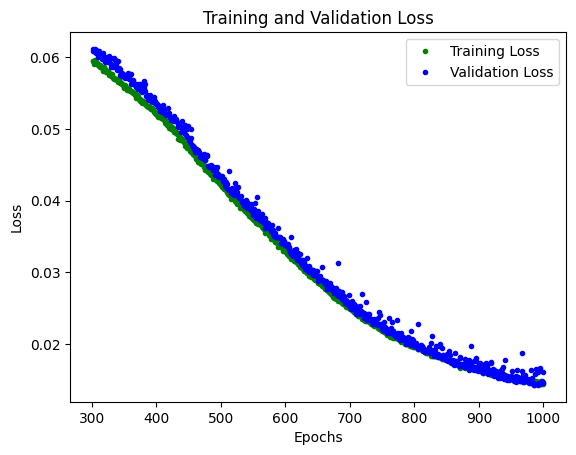

In [11]:
#zoom into the graph
SKIP = 300

plt.plot(epoch[SKIP:],loss[SKIP:], 'g.', label = 'Training Loss')
plt.plot(epoch[SKIP:], val_loss[SKIP:], 'b.', label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

but even MAE is at ~0.3, when our expected value is -1 to +1, so error of 0.31 means it is very far from accurate

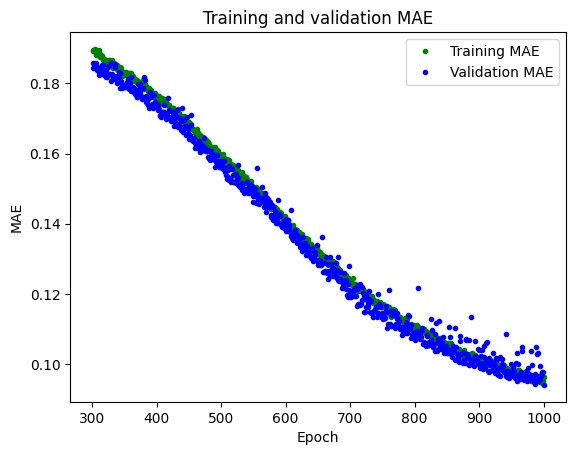

In [12]:
mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epoch[SKIP:],mae[SKIP:],'g.', label='Training MAE')
plt.plot(epoch[SKIP:],val_mae[SKIP:], 'b.', label = "Validation MAE")
plt.title('Training and validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

plot the prediction

19/19 [==============================] - 0s 2ms/step


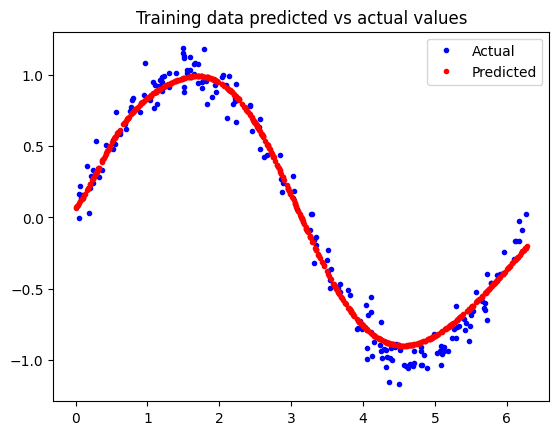

In [13]:
predictions = model_1.predict(x_train)

plt.clf()
plt.title("Training data predicted vs actual values")
plt.plot(x_test, y_test, 'b.', label = 'Actual')
plt.plot(x_train, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

Altho changing to sigmoid (I changed myself not by textboox) kinda works, lets experiment by building a more complexed model with more layers

Building a model with 1 more dense (fully connected layer)

In [14]:
model_2 = tf.keras.Sequential()

model_2.add(layers.Dense(16, activation = 'relu', input_shape=(1,)))
model_2.add(layers.Dense(16, activation = 'relu'))
model_2.add(layers.Dense(1))

model_2.compile(optimizer= 'rmsprop', loss='mse', metrics=['mae'])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                32        
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history_2 = model_2.fit(x_train, y_train, epochs = 600, batch_size = 16, validation_data = (x_validate, y_validate))

Epoch 1/600
38/38 [==============================] - 1s 7ms/step - loss: 1.0169 - mae: 0.8527 - val_loss: 0.5507 - val_mae: 0.6635
Epoch 2/600
38/38 [==============================] - 0s 3ms/step - loss: 0.4487 - mae: 0.5849 - val_loss: 0.4339 - val_mae: 0.5661
Epoch 3/600
38/38 [==============================] - 0s 3ms/step - loss: 0.3737 - mae: 0.5286 - val_loss: 0.3659 - val_mae: 0.5261
Epoch 4/600
38/38 [==============================] - 0s 3ms/step - loss: 0.3168 - mae: 0.4879 - val_loss: 0.3084 - val_mae: 0.4784
Epoch 5/600
38/38 [==============================] - 0s 3ms/step - loss: 0.2675 - mae: 0.4514 - val_loss: 0.2566 - val_mae: 0.4332
Epoch 6/600
38/38 [==============================] - 0s 3ms/step - loss: 0.2258 - mae: 0.4151 - val_loss: 0.2247 - val_mae: 0.4025
Epoch 7/600
38/38 [==============================] - 0s 3ms/step - loss: 0.1977 - mae: 0.3887 - val_loss: 0.1983 - val_mae: 0.3830
Epoch 8/600
38/38 [==============================] - 0s 3ms/step - loss: 0.1774 - m

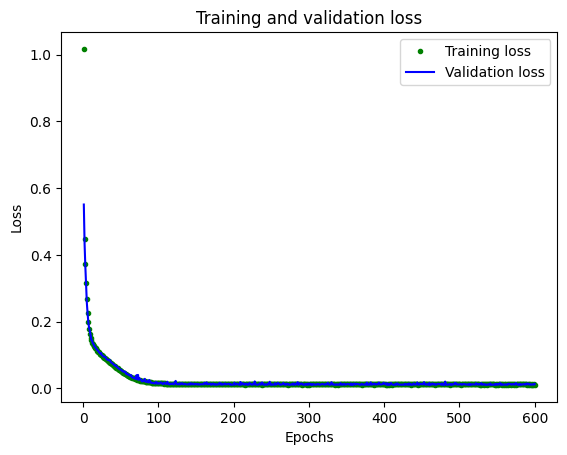

In [16]:
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

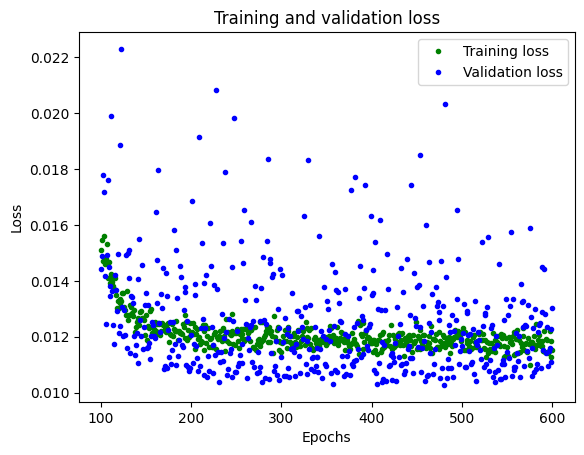

In [17]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 100
plt.clf()
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

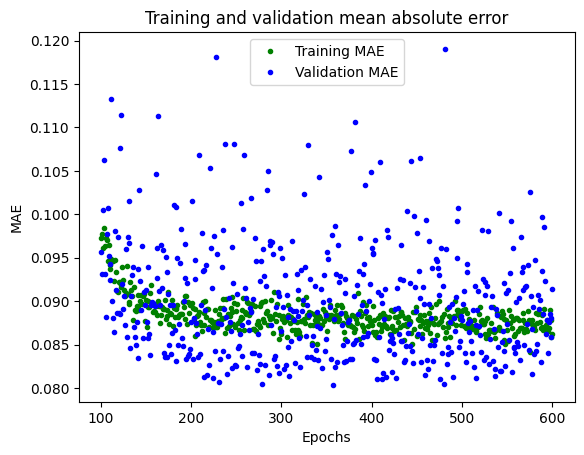

In [18]:
plt.clf()
# Draw a graph of mean absolute error, which is another way of # measuring the amount of error in the prediction.
mae = history_2.history['mae']
val_mae = history_2.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Test the model.
If even after optimizing (adding new layers etc) didnt work then we prolly have to rethink over.

7/7 [==============================] - 0s 2ms/step


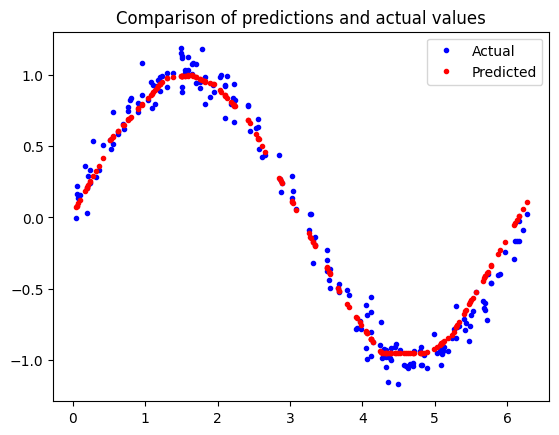

In [19]:
# Calculate and print the loss on our test dataset
loss = model_2.evaluate(x_test, y_test)
# Make predictions based on our test dataset
predictions = model_2.predict(x_test)
# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

Conclusion: Model has learnt how to predict a sine curve even when the dataset is noisy.

In [20]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()

# Save the model to disk

open("sine_model.tflite","wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)

# Indicate that we want to perform the default optimizations, including quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Define a generator function that provides our test data's x values # as a representative dataset, and tell the converter to use it
def representative_dataset_generator():
  for value in x_test:
    # Each scalar value must be inside of a 2D array that is wrapped in a list
    yield [np.array(value, dtype=np.float32, ndmin=2)]

converter.representative_dataset = representative_dataset_generator

# Convert the model
tflite_model = converter.convert()

# Save the model to disk
open("sine_model_quantized.tflite", "wb").write(tflite_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


3040

Interpreting with TensorFlow lite

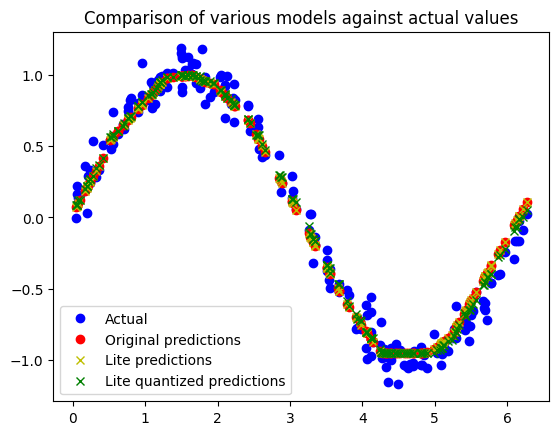

In [21]:
# Instantiate an interpreter for each model
sine_model = tf.lite.Interpreter('sine_model.tflite')
sine_model_quantized = tf.lite.Interpreter('sine_model_quantized.tflite')
# Allocate memory for each model
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()
# Get indexes of the input and output tensors
sine_model_input_index = sine_model.get_input_details()[0]["index"]
sine_model_output_index = sine_model.get_output_details()[0]["index"]
sine_model_quantized_input_index = sine_model_quantized.get_input_details()[0] ["index"]
sine_model_quantized_output_index = sine_model_quantized.get_output_details()[0]["index"]
# Create arrays to store the results
sine_model_predictions = []
sine_model_quantized_predictions = []

# Run each model's interpreter for each value and store the results in arrays
for x_value in x_test:
# Create a 2D tensor wrapping the current x value
  x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
 # Write the value to the input tensor
  sine_model.set_tensor(sine_model_input_index, x_value_tensor)
 # Run inference
  sine_model.invoke()
# Read the prediction from the output tensor
  sine_model_predictions.append( sine_model.get_tensor(sine_model_output_index)[0])
# Do the same for the quantized model
  sine_model_quantized.set_tensor(sine_model_quantized_input_index, x_value_tensor)
  sine_model_quantized.invoke()
  sine_model_quantized_predictions.append( sine_model_quantized.get_tensor(sine_model_quantized_output_index)[0])

# See how they line up with the data
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual')
plt.plot(x_test, predictions, 'ro', label='Original predictions')
plt.plot(x_test, sine_model_predictions, 'yx', label='Lite predictions')
plt.plot(x_test, sine_model_quantized_predictions, 'gx', label='Lite quantized predictions')
plt.legend()
plt.show()

Comparing the sizes

In [22]:
import os
basic_model_size = os.path.getsize("sine_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("sine_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Basic model is 3192 bytes
Quantized model is 3040 bytes
Difference is 152 bytes


Converting to C file
(Unix tool to convert, or can even do with a python function to convert hex to c array in CE4172 lecture slide)

In [24]:
#Unix tool XXD converts the given file to the required format
!apt-get -qq install xxd
#Save the file as C source file
!xxd -i sine_model_quantized.tflite > sine_model_quantized.h
#Print source file
!cat sine_model_quantized.cc

unsigned char sine_model_quantized_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x88, 0x00, 0x00, 0x00, 0xe0, 0x00, 0x00, 0x00, 0xac, 0x03, 0x00, 0x00,
  0xbc, 0x03, 0x00, 0x00, 0x58, 0x0b, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x02, 0xfc, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x94, 0xff, 0xff, 0xff, 0x0b, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x34, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xd6, 0xfc, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00, 0x0d, 0x00, 0x